# **Emotion Mining on Comments About Tom Lembong Case**

- Nama : Muhamad Habibi Budiman
- NIM  : 102022300226
- CaAs : 2506

## **Import Library**

In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModel

# **Load Data**

In [76]:
tr = pd.read_csv('drive/MyDrive/LASWeek4/LASWeek4/train.csv')
ts = pd.read_csv('drive/MyDrive/LASWeek4/LASWeek4/test.csv')
print ("Data Train dan Data Test Sudah terbaca! ")

Data Train dan Data Test Sudah terbaca! 


Melihat data awal

In [77]:
tr.head()

,id_comment,source,text,label
0,UID0000,Instagram,makin dewasa makin sadar bahwa taktik pemerint...,SADNESS
1,UID0001,X / Twitter,Membuktikan hal yg benar di pengadilan itu mmg...,ANGER
2,UID0002,Instagram,RIP keadilan di Indonesia 🥀🥀🥀,SADNESS
3,UID0003,Instagram,"Dengan adanya pinjol, judol dan para rentenir ...",ANGER
4,UID0004,Instagram,@revandioctareza negri Morat marit🥀,SADNESS


In [78]:
ts.head()

,id_comment,source,text
0,UID5083,Instagram,Rusaknya tatanan hukum di negeri ini sejak mun...
1,UID5084,Instagram,sebaik ini padahal 😢
2,UID5085,Instagram,Orang ini akan di tagih di akhirat ingat ya hu...
3,UID5086,Instagram,Semangat Pak Tom
4,UID5087,Instagram,RIP keadilannn 💔🥀🥺


Melihat statistik deskriptif ringkas Data

In [79]:
tr.describe()

,id_comment,source,text,label
count,5083,5083,5083,5083
unique,5083,2,5083,5
top,UID5082,Instagram,buat apa 17 Agustus kalo kegini yg dinamakan m...,SADNESS
freq,1,4985,1,1410


In [80]:
ts.describe()

,id_comment,source,text
count,1695,1695,1695
unique,1695,2,1695
top,UID6777,Instagram,Masalahnya sederhana Pak Tom Lembong... Karena...
freq,1,1663,1


Mendapatkan Informasi dari Dataset

In [81]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5083 entries, 0 to 5082
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_comment  5083 non-null   object
 1   source      5083 non-null   object
 2   text        5083 non-null   object
 3   label       5083 non-null   object
dtypes: object(4)
memory usage: 159.0+ KB


In [82]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_comment  1695 non-null   object
 1   source      1695 non-null   object
 2   text        1695 non-null   object
dtypes: object(3)
memory usage: 39.9+ KB


Memeriksa Duplikasi Data

In [83]:
print("Jumlah duplikasi data pada data Train : ", tr.duplicated().sum())
print("Jumlah duplikasi data pada data Test : ", ts.duplicated().sum())

Jumlah duplikasi data pada data Train :  0
Jumlah duplikasi data pada data Test :  0


Memeriksa Missing Value

In [84]:
print("Jumlah Missing value data Train : ", tr.isnull().sum())
print("\nJumlah Missing value data Test : ", ts.isnull().sum())

Jumlah Missing value data Train :  id_comment    0
source        0
text          0
label         0
dtype: int64

Jumlah Missing value data Test :  id_comment    0
source        0
text          0
dtype: int64


Visualisasi Outliers

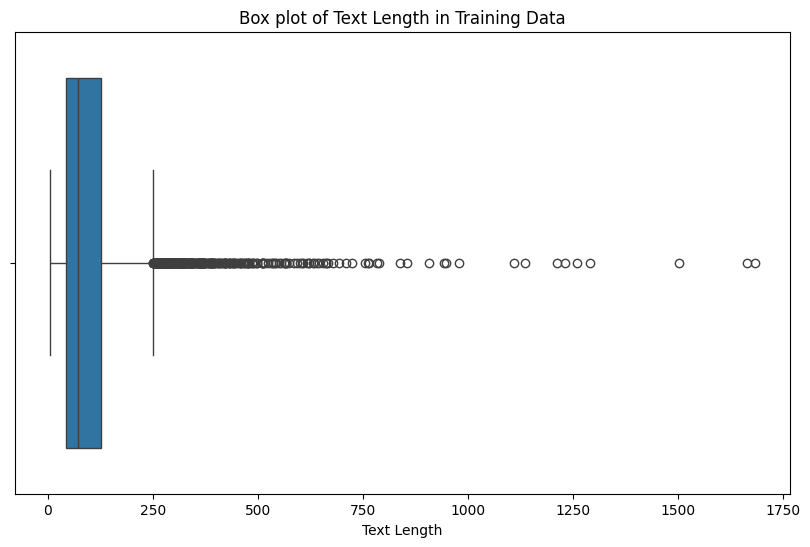

In [85]:
tr['text_length'] = tr['text'].apply(len)
ts['text_length'] = ts['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x=tr['text_length'])
plt.title('Box plot of Text Length in Training Data')
plt.xlabel('Text Length')
plt.show()

## **EDA**

Visualisasi distribusi kolom label dari Data Train

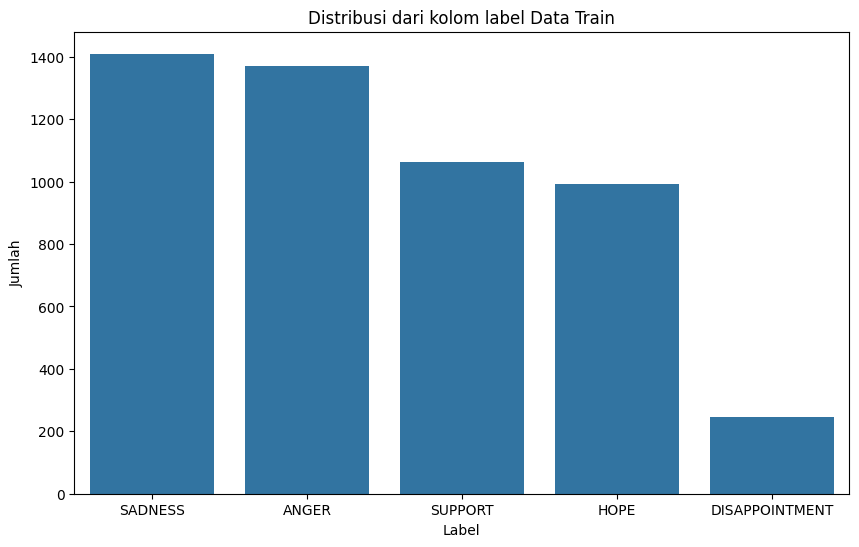

In [86]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=tr, order = tr['label'].value_counts().index)
plt.title('Distribusi dari kolom label Data Train')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

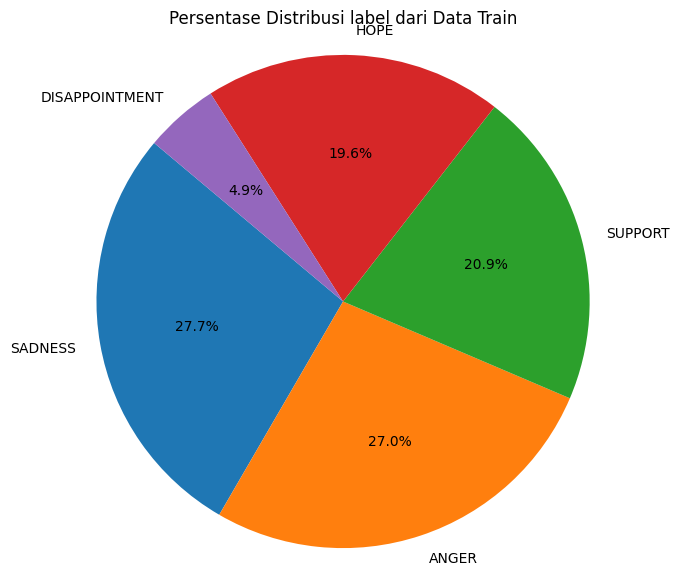

In [87]:
label_counts = tr['label'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Persentase Distribusi label dari Data Train')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Visualisasi Distribusi Source Pada Data Train

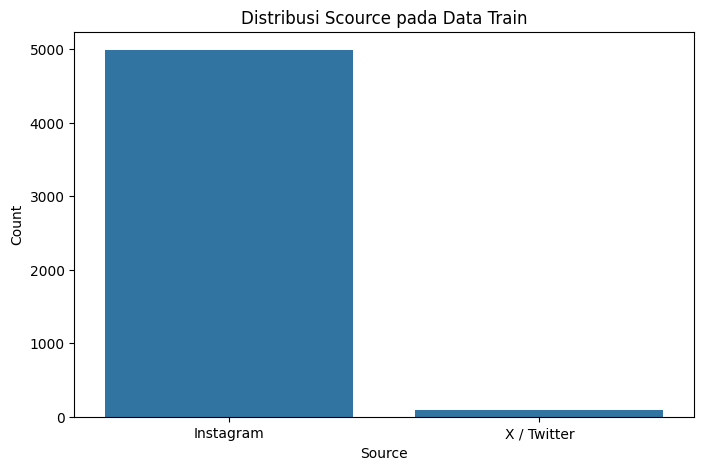

In [88]:
plt.figure(figsize=(8, 5))
sns.countplot(x='source', data=tr, order = tr['source'].value_counts().index)
plt.title('Distribusi Scource pada Data Train')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

Visualisasi Distribusi Source Pada Data Test

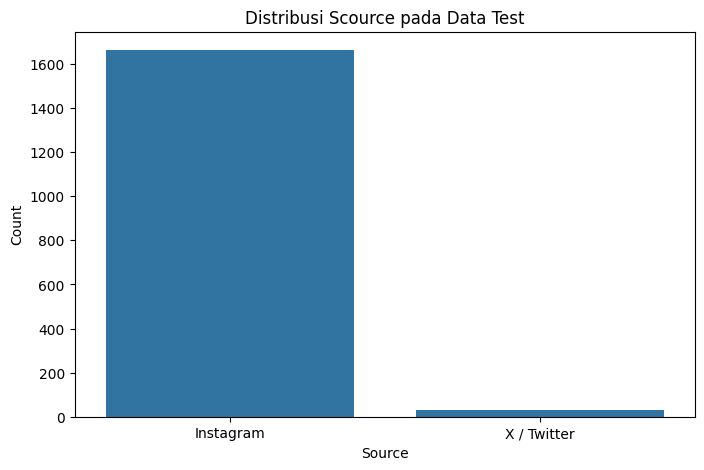

In [89]:
plt.figure(figsize=(8, 5))
sns.countplot(x='source', data=ts, order = ts['source'].value_counts().index)
plt.title('Distribusi Scource pada Data Test')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

## **pra-pemrosesan**

In [125]:
# Download stopwords Indonesia jika belum ada
nltk.download('stopwords')
from nltk.corpus import stopwords

# Inisialisasi stopwords Indonesia
stop_words = set(stopwords.words('indonesian'))

# Menambah daftar stopwords tambahan yang sering muncul di dataset
additional_stopwords = ['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'pak', 'tom']

stop_words.update(additional_stopwords)

# Fungsi untuk membersihkan teks
def clean_text(text):
    # Menghapus karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)
    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    # Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text)
    # Menghapus spasi di awal dan akhir
    text = text.strip()
    return text

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Inisialisasi stemmer
stemmer = PorterStemmer()

# Fungsi untuk stemming
def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Aplikasikan pembersihan teks pada data train dan test
tr['cleaned_text'] = tr['text'].apply(clean_text)
ts['cleaned_text'] = ts['text'].apply(clean_text)

# Hapus stopwords
tr['cleaned_text'] = tr['cleaned_text'].apply(remove_stopwords)
ts['cleaned_text'] = ts['cleaned_text'].apply(remove_stopwords)

# Lakukan stemming
tr['cleaned_text'] = tr['cleaned_text'].apply(stem_text)
ts['cleaned_text'] = ts['cleaned_text'].apply(stem_text)

# Hapus baris yang mungkin menjadi kosong setelah pembersihan
tr = tr[tr['cleaned_text'].str.len() > 0]
ts = ts[ts['cleaned_text'].str.len() > 0]

# Tampilkan hasil
print("Data setelah pembersihan:")
tr[['text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data setelah pembersihan:


,text,cleaned_text
0,makin dewasa makin sadar bahwa taktik pemerint...,dewasa sadar taktik pemerintah semengerikan
1,membuktikan hal yg benar di pengadilan itu mmg...,membuktikan pengadilan mmg syusah sebersih ses...
2,rip keadilan di indonesia,rip keadilan indonesia
3,dengan adanya pinjol judol dan para rentenir b...,pinjol judol rentenir penipuan peretasan akun ...
4,revandioctareza negri morat marit,revandioctareza negri morat marit


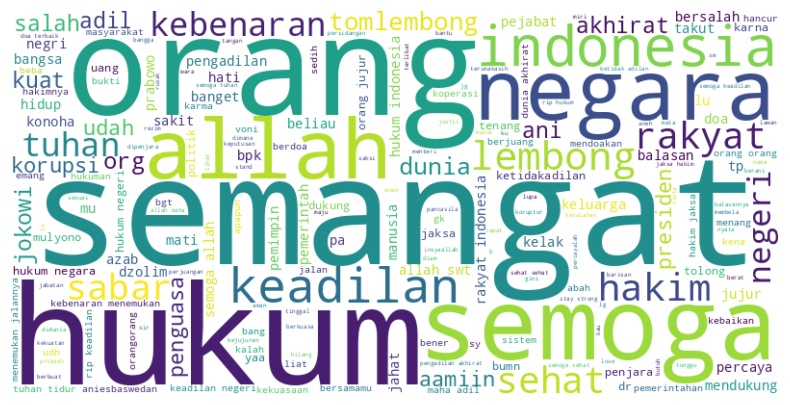

In [130]:
# Gabungkan semua teks yang sudah dibersihkan dari data train
all_cleaned_text = ' '.join(tr['cleaned_text'])

# Buat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)

# Tampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [131]:
from sklearn.preprocessing import LabelEncoder
# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(tr['cleaned_text'])

# Konversi teks menjadi sequences
train_sequences = tokenizer.texts_to_sequences(tr['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(ts['cleaned_text'])

# Padding sequences
max_length = 100  # Sesuaikan dengan panjang teks rata-rata
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Persiapan label
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(tr['label'])
num_classes = len(np.unique(train_labels))

In [136]:
from transformers import BertTokenizer, TFAutoModel
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-large-p2")
model = TFAutoModel.from_pretrained("indobenchmark/indobert-large-p2")

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-large-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-large-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
